# Imports and Paths

In [1]:
import os
import sys
from sklearn.ensemble import *
from copy import deepcopy

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
# PATH_base = '/home/bj/git/data_science/'
# PATH_bd = '/data/blue_book/'
# PATH_func = PATH_base + 'src/'

In [3]:
if os.name == 'nt':
    PATH_base = 'E:\\GitHub\\data_science\\'
    PATH_bd = 'E:\\GitHub\\data_science\\data\\uncompressed\\blue_book_for_bulldozers\\'
    PATH_func = 'E:\\GitHub\\data_science\\src\\'
    sys.path.append(PATH_func)
elif os.name == 'posix':
    PATH = '/home/msnow/git/data_science/'
    DATA = '/data/msnow/data_science/'
    sys.path.append(PATH+'src/')

In [4]:
sys.path

['',
 '/data/msnow/miniconda3/envs/data_sci/lib/python36.zip',
 '/data/msnow/miniconda3/envs/data_sci/lib/python3.6',
 '/data/msnow/miniconda3/envs/data_sci/lib/python3.6/lib-dynload',
 '/data/msnow/miniconda3/envs/data_sci/lib/python3.6/site-packages',
 '/data/msnow/miniconda3/envs/data_sci/lib/python3.6/site-packages/IPython/extensions',
 '/home/msnow/.ipython',
 '/home/msnow/git/data_science/src/']

In [279]:
from features.imports import *
from features.utilities import *
from features.fastai import * 

In [10]:
%ls ..\\data\\uncompressed\\blue_book_for_bulldozers\\

 Volume in drive E is Storage
 Volume Serial Number is D098-4C8A

 Directory of E:\GitHub\data_science\data\uncompressed\blue_book_for_bulldozers

03/24/2018  04:37 PM    <DIR>          .
03/24/2018  04:37 PM    <DIR>          ..
01/24/2013  09:08 PM       116,403,970 Train.csv
01/24/2013  07:11 PM         3,318,969 Valid.csv
               2 File(s)    119,722,939 bytes
               2 Dir(s)  1,852,864,679,936 bytes free


# Save to/Load from Feather

In [6]:
# df_raw.to_feather(f'{DATA}/bbfb/bulldozer')
df_raw = pd.read_feather(f'{DATA}/bbfb/bulldozer')
# df_raw_orig = pd.read_feather(f'{DATA}/bbfb/bulldozer_raw')

In [28]:
df, y, na_dict = proc_df(df_raw, 'SalePrice')

In [9]:
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1248307200


In [29]:
n_trn = len(df)-12000
_, X_valid = split_train_val(df,trn_amount=n_trn)
_, y_valid = split_train_val(y,trn_amount=n_trn)
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=na_dict)
X_train, _ = split_train_val(df_trn, trn_amount=20000)
y_train, _ = split_train_val(y_trn, trn_amount=20000)
m = RandomForestRegressor(n_jobs=-1);
m.fit(X_train, y_train);
def print_custom_RFscore():
    train_rmse = custom_RFscore(m, X_train, y_train)
    valid_rmse = custom_RFscore(m, X_valid, y_valid) 
    train_score = m.score(X_train, y_train)
    valid_score = m.score(X_valid, y_valid)
    print(f'Training rmse: {train_rmse}')
    print(f'Validation rmse: {valid_rmse}')
    print(f'Training Score: {train_score}')
    print(f'Validation Score: {valid_score}')
    if hasattr(m, 'oob_score_'):
        print(f'OOB Score: {m.oob_score_}')

# $r^2$ and RMSE

Let's run a simple random forest regressor on our dataset

In [31]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df, y)

0.9824105402447549

This score is the $r^2$ which is defined as :

$$r^2 = 1-\dfrac{SS_{res}}{SS_{tot}}  = 1-\dfrac{\sum\limits_i\left(y_i-f_i\right)^2}{\sum\limits_i\left(y_i-\bar{y}\right)^2}$$

where $y_i$ is the true output, $f_i$ is the model output and $\bar{y}$ is the mean true output.  Intepretation of different $r^2$ values is as follows
  1. $r^2 = 1$ means that the model perfectly predicts the output
  1. $r^2 = 0$ means the model does no better than predicting the output using the mean output, i.e., $\bar{y}$
  1. $1 > r^2 > 0 $ means that the model is better than simply using the mean ouptut
  1. $r^2 < 0$ means that the model is worse than just using the mean output as a predictor
 
However, $r^2$ by itself, is not a good metric as an overfit model will have an $r^2$ close to 1 for the training set, but would do much worse on a test set. 

To overcome the issue of overfitting, we can split the data into a training and validation set; using the training set to build the model and the validation set to test how good the model does on a different set of data.

In [32]:
n_trn = len(df)-12000
X_train, X_valid = split_train_val(df,trn_amount=n_trn)
y_train, y_valid = split_train_val(y,trn_amount=n_trn)

X_train.shape, y_train.shape, X_valid.shape

((38000, 65), (38000,), (12000, 65))

In [33]:
train_rmse = custom_RFscore(m, X_train, y_train)
valid_rmse = custom_RFscore(m, X_valid, y_valid) 
train_score = m.score(X_train, y_train)
valid_score = m.score(X_valid, y_valid)
print(f'Training rmse: {train_rmse}')
print(f'Validation rmse: {valid_rmse}')
print(f'Training Score: {train_score}')
print(f'Validation Score: {valid_score}')

Training rmse: 0.09349769556571906
Validation rmse: 0.0688803687875353
Training Score: 0.9834323702372217
Validation Score: 0.9718148732063945


# Speeding Things Up

In [34]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=na_dict)
X_train, _ = split_train_val(df_trn, trn_amount=20000)
y_train, _ = split_train_val(y_trn, trn_amount=20000)

In [35]:
m = RandomForestRegressor(n_jobs=-1);
m.fit(X_train, y_train);

test

In [36]:
train_rmse = custom_RFscore(m, X_train, y_train)
valid_rmse = custom_RFscore(m, X_valid, y_valid) 
train_score = m.score(X_train, y_train)
valid_score = m.score(X_valid, y_valid)
print(f'Training rmse: {train_rmse}')
print(f'Validation rmse: {valid_rmse}')
print(f'Training Score: {train_score}')
print(f'Validation Score: {valid_score}')

Training rmse: 0.09821146385156575
Validation rmse: 0.1408816580112238
Training Score: 0.9781615564366094
Validation Score: 0.8820934386314245


In [37]:
def print_custom_RFscore():
    train_rmse = custom_RFscore(m, X_train, y_train)
    valid_rmse = custom_RFscore(m, X_valid, y_valid) 
    train_score = m.score(X_train, y_train)
    valid_score = m.score(X_valid, y_valid)
    print(f'Training rmse: {train_rmse}')
    print(f'Validation rmse: {valid_rmse}')
    print(f'Training Score: {train_score}')
    print(f'Validation Score: {valid_score}')

# Single Tree

In [4]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.5392840105293845
Validation rmse: 0.5794726966342749
Training Score: 0.40094421266106184
Validation Score: 0.4003277810486982


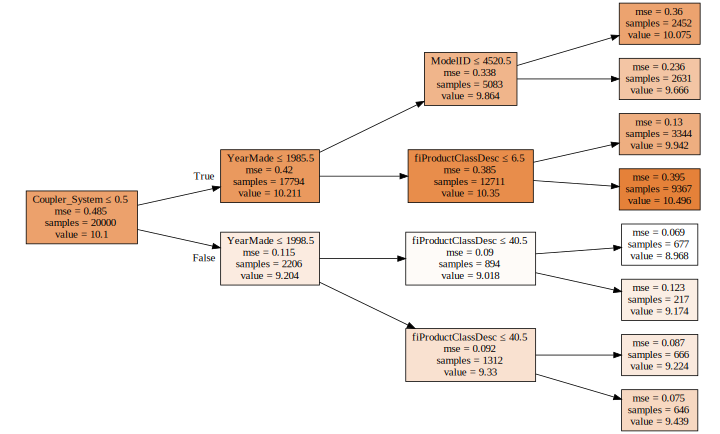

In [5]:
draw_tree(m.estimators_[0], df_trn, precision=3)

## Interpreting the Decision Tree

If I took the mean output of my entire dataset and used that to predict the output for each individual observation, what would the mean square error be?

In [40]:
mse = ((y_train - y_train.mean())**2).mean()
print(f'mean square error = {round(mse,3)}')
print(f'samples = {len(y_train)}')
print(f'mean value = {round(y_train.mean(),3)}')

mean square error = 0.442
samples = 20000
mean value = 9.941


Taking a look at the tree above, we can now see that the `values` and `mse` term of the first box correspond to the mean output value and mean squared error using the output value of the entire dataset. Let's see if this analysis holds true for the next couple of boxes.

In [41]:
y_train_2_1 = y_train[list(X_train.Coupler_System <= 0.5)]
mse = ((y_train_2_1 - y_train_2_1.mean())**2).mean()
print(f'mean square error = {round(mse,3)}')
print(f'samples = {len(y_train_2_1)}')
print(f'mean value = {round(y_train_2_1.mean(),3)}')

mean square error = 0.386
samples = 16380
mean value = 10.093


In [42]:
y_train_2_2 = y_train[list(X_train.Coupler_System > 0.5 )]
mse = ((y_train_2_2 - y_train_2_2.mean())**2).mean()
print(f'mean square error = {round(mse,3)}')
print(f'samples = {len(y_train_2_2)}')
print(f'mean value = {round(y_train_2_2.mean(),3)}')

mean square error = 0.113
samples = 3620
mean value = 9.252


In [43]:
y_train_3_1 = y_train[list((X_train.Coupler_System <= 0.5)  & (X_train.YearMade <= 1991.5))]
mse = ((y_train_3_1 - y_train_3_1.mean())**2).mean()
print(f'mean square error = {round(mse,3)}')
print(f'samples = {len(y_train_3_1)}')
print(f'mean value = {round(y_train_3_1.mean(),3)}')

mean square error = 0.254
samples = 6749
mean value = 9.737


# Bagging

The problem with using a single tree is that the smaller the leaf nodes are, the more overfit the model is.  When the leaf nodes only have a single value in them, the model is perfectly predicts the training set but does not score nearly as high on the validation set

In [46]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 2.3874896000997127e-06
Validation rmse: 0.17997538860410744
Training Score: 0.9999999999870944
Validation Score: 0.8075777425128688


## Bagging Tutorial

To go from single decision trees to a random forest, you want to somehow combine multiple decision trees to end up with a result that is somehow better than any single decision tree.  This act of combining models to get a better model is called ensembling.  For the random forest, the idea being that you create lots of "bad" decision trees, where each one does contain some insight about your data as well as significantly overfitting the data (high score on training set, low score on validation set).  If you repeat this with lots of uncorrelated trees then their overfitting errors, which are randomly distributed, should average to zero, while retaining each individual tree's true information.

To uncorrelate the data we can randomly choose a subset of the data for each decision tree.

Lucky for us this is what scikit-learn does by default (this is the bootstrap parameter in the RandomForestRegressor (RFR)).  Technically, the RFR, picks out n_rows with replacement.

In [6]:
m = RandomForestRegressor(n_estimators=3, max_depth=2, bootstrap=True, n_jobs=-1, max_features=0.5)
m.fit(X_train, y_train);

In [36]:
X_samp = X_valid.sample(3)
preds = np.stack([t.predict(X_samp) for t in m.estimators_])

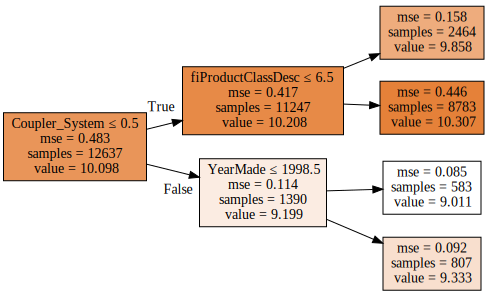

In [41]:
draw_tree(m.estimators_[0], df_trn, precision=3)

In [42]:
tree = m.estimators_[0].tree_
tree_features = X_train.columns[tree.feature[tree.feature>0]].tolist()
X_pred0 = X_samp[tree_features].copy()
X_pred0['prediction'] = np.round(preds[0,:],3)
X_pred0

,Coupler_System,fiProductClassDesc,YearMade,prediction
393484,0,49,1989,10.307
390375,1,41,2005,9.333
399437,0,14,1000,10.307


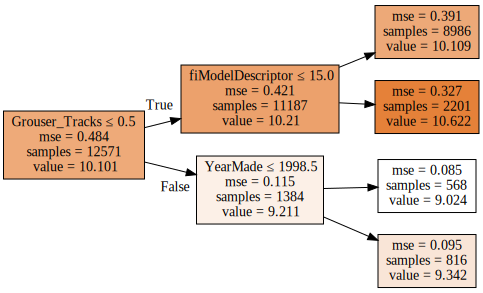

In [43]:
draw_tree(m.estimators_[1], df_trn, precision=3)

In [44]:
tree = m.estimators_[1].tree_
tree_features = X_train.columns[tree.feature[tree.feature>0]].tolist()
X_pred1 = X_samp[tree_features].copy()
X_pred1['prediction'] = np.round(preds[1,:],3)
X_pred1

,Grouser_Tracks,fiModelDescriptor,YearMade,prediction
393484,0,71,1989,10.622
390375,2,0,2005,9.342
399437,0,20,1000,10.622


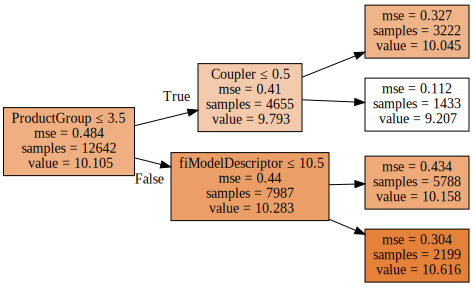

In [45]:
draw_tree(m.estimators_[2], df_trn, precision=3)

In [46]:
tree = m.estimators_[2].tree_
tree_features = X_train.columns[tree.feature[tree.feature>0]].tolist()
X_pred2 = X_samp[tree_features].copy()
X_pred2['prediction'] = np.round(preds[2,:],3)
X_pred2

,ProductGroup,Coupler,fiModelDescriptor,prediction
393484,5,0,71,10.616
390375,3,3,0,9.207
399437,4,3,20,10.616


Comparing the average prediction for each sample to the output of the predict function gives the same result.  This demonstrates how the random forest computes the prediction for each sample.

In [50]:
print(f'Average prediction: {np.mean(preds,axis=0)}')
print(f'predict function: {m.predict(X_samp)}')

Average prediction: [10.51478961  9.29399394 10.51478961]
predict function: [10.51478961  9.29399394 10.51478961]


Since the errors are randomly distributed, in theory, the predictions from the trees should form a normal distribution.

In [42]:
m = RandomForestRegressor(n_estimators=1000, bootstrap=True, n_jobs=-1, max_features=0.5)
m.fit(X_train, y_train);
X_samp = X_valid.sample(1)
preds = np.stack([t.predict(X_samp) for t in m.estimators_])

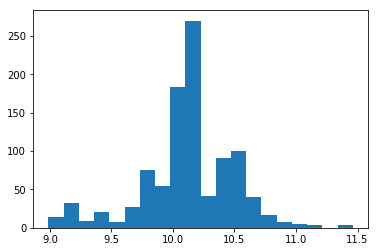

In [97]:
plt.hist(preds, bins=20);

### Prediction Confidence

Bagging averages the predictions across many trees, but how confident can we be in this prediction?  If the predictions are all relatively similar this would engender more confidence than if the predictions were  from a much broader distribution.  This can be quantified by calculating the standard deviation of the prediction.  The smaller the ratio of the standard deviation to the average prediction the more confident you can be in your prediction

In [18]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.15051800836347037
Validation rmse: 0.265466363688882
Training Score: 0.9527450322708134
Validation Score: 0.8741460137038124
OOB Score: 0.8465987303500939


In [19]:
def get_preds(t): return t.predict(X_valid)
preds = np.stack(parallel_trees(m, get_preds))

In [34]:
raw_train, raw_valid = split_train_val(df_raw, n_trn)
x = deepcopy(raw_valid)
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x['counts'] = 1
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
# summ = x[flds].groupby(flds[0]).agg({'SalePrice':['mean', 'count'],'pred':'mean','pred_std':'mean'})
summ['counts'] = x[['ProductSize','counts']].groupby(flds[0]).count()
summ

,SalePrice,pred,pred_std,counts
ProductSize,,,,
Compact,9.735093,9.805032,0.360261,143
Large,10.470589,10.429850,0.380904,297
Large / Medium,10.691871,10.680486,0.302698,1706
Medium,10.681511,10.680105,0.307488,1549
Mini,9.535147,9.549701,0.263480,1369
Small,10.324448,10.312925,0.358018,624


In [35]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Compact           0.036742
Large             0.036521
Small             0.034715
Medium            0.028791
Large / Medium    0.028341
Mini              0.027590
dtype: float64

What you can see here is that they all have relatively similar ratios and the size of the ratio correlates with the number of counts of the feature.  This strengthens our belief that the prediction is valid.

## Implementing Bagging

Starting with the basic model

In [51]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.11667995856565676
Validation rmse: 0.2869778625125253
Training Score: 0.9719569844490079
Validation Score: 0.8529229985551873


In [62]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])

We can demonstrate how the predictive ability of the RF model increases with the number of ensembled decision trees

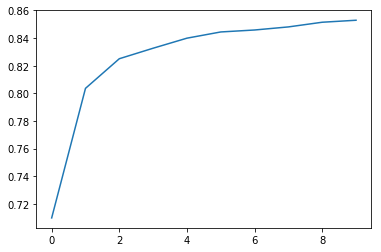

In [64]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

Let's see how the validation score improves as a function of the number of tree

In [101]:
m = RandomForestRegressor(n_jobs=-1,n_estimators=10)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.11691499918113024
Validation rmse: 0.2812932565924041
Training Score: 0.9718438907106337
Validation Score: 0.8586920434907607


In [98]:
m = RandomForestRegressor(n_jobs=-1,n_estimators=20)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.1080910718330679
Validation rmse: 0.27643686348845103
Training Score: 0.9759335614124797
Validation Score: 0.8635291528569986


In [99]:
m = RandomForestRegressor(n_jobs=-1,n_estimators=40)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.10150961937253764
Validation rmse: 0.27146211215209665
Training Score: 0.9787750547329871
Validation Score: 0.8683968084199611


In [100]:
m = RandomForestRegressor(n_jobs=-1,n_estimators=80)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.09827296154985389
Validation rmse: 0.27020073279601015
Training Score: 0.980107000641755
Validation Score: 0.869616985153063


You can see that the validation score does improve, but there is diminishing returns

## Out-of-Bag (OOB) score 

You can see in the cases above that even with the bagging and increasing the number of trees, the validation score is still significantly lower than the training score.  This often means that we are overfitting the model.  But maybe the validation set is just statistically different than the training set, in which case the validation score will always be lower.  To test this possibility we can do something call Out-of-Bagging (OOB).  

When using bagging, we are only selecting n-rows for each tree.  For example, if there are 20 trees built, row 1 could be used only in trees 1, 7, 13, and 15.  If that's the case, then tree 2 was not trained using row 1 and so it can be used as a validation set for tree 2.  This is what OOB does, it uses each row as part of the validation set, but only for the trees which did not use it to train.  Since the OOB validation set comes from same data as the training set, any difference is scores is due to overfitting and not statistically distinct sets.

In [110]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train);
print_custom_RFscore()

Training rmse: 0.10155569125594387
Validation rmse: 0.26677607867147174
Training Score: 0.97851026448116
Validation Score: 0.8729011142596962
OOB Score: 0.847722291172098


Practically, the oob score slightly underestimates the generalizability of the model, but this decreases as a function of the number of samples.

In this case you can see that the oob score is very similar to the validation score, which confirms that the drop in score is most probably due to overfitting and not different distributions.

# Reducing Overfitting

## Subsampling

To make the random forest faster, I subsampled from the original dataset 20,000 rows, and then built all of my decision trees, with boostrapping and oob_score, on those subset of rows.  An alternative is to build each tree from a sample of 20,000 rows, from my entire dataset, for each tree.  This allows you to take advantage of a faster model (less samples) while accessing a larger training and validation set.

In [116]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_train_val(df_trn, n_trn)
y_train, y_valid = split_train_val(y_trn, n_trn)

In [122]:
set_rf_samples(20000)

In [120]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.24126072065343024
Validation rmse: 0.2767189887773357
Training Score: 0.8783511332334722
Validation Score: 0.8632504525146026
OOB Score: 0.8656224989110298


In [121]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True, n_estimators=40)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.22731397154924346
Validation rmse: 0.2618011618093503
Training Score: 0.8920091185938114
Validation Score: 0.8775972675089081
OOB Score: 0.8804921832235565


Now you can see that while our validation and oob_scores have not improved, the training score has decreased.  While this might seem like a bad thing, what this implies is that now, we are no longer ovrefitting the model.

Be aware that currently, the oob score still only looks at the unused rows of the sample set, not the entire dataset.

## Tree Building Parameters

To demonstrate the improvement of modifying the RFR options, I am going to go back to using the original parameters

In [130]:
reset_rf_samples()
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.0783123950644594
Validation rmse: 0.23699000175463975
Training Score: 0.987182720971379
Validation Score: 0.8996983627129161
OOB Score: 0.9086158701976964


Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with `min_samples_leaf`) that we require some minimum number of rows in every leaf node. This has two benefits:

 - There are less decision rules for each leaf node; simpler models should generalize better
 - The predictions are made by averaging more rows in the leaf node, resulting in less volatility (and higher confidence)

In [132]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.11511535517453375
Validation rmse: 0.2360507832161104
Training Score: 0.9723050017727247
Validation Score: 0.9004918011159826
OOB Score: 0.9085097009274974


We can also increase the amount of variation amongst the trees by not only use a sample of rows for each tree, but to also using a sample of columns for each split. We do this by specifying max_features, which is the proportion of features to randomly select from at each split.

 - None
 - 0.5
 - 'sqrt'
 - An integer value, e.g., 1, 3, 5

In [131]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_custom_RFscore() 

Training rmse: 0.11902840748625773
Validation rmse: 0.2280451534681458
Training Score: 0.9703901592068734
Validation Score: 0.9071269586823107
OOB Score: 0.9118430414192688


# Feature Importance

## Overview

In addition to being able to make accurate predictions it is important to be able to identify which factors are the most important in making that prediction.

In [31]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
_, X_valid = split_train_val(df,trn_amount=n_trn)
_, y_valid = split_train_val(y,trn_amount=n_trn)
X_train, _ = split_train_val(df_trn, trn_amount=20000)
y_train, _ = split_train_val(y_trn, trn_amount=20000)

In [32]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.08948517205633925
Validation rmse: 0.32368197892517436
Training Score: 0.9838122313908888
Validation Score: 0.8128951628771871
OOB Score: 0.8850240360982262


The RFR stores the feature importances for every feature in a variable appropriately named `m.feature_importances_`.  The values are the relative importance of each feature and they sum to 1.

In [36]:
sum(m.feature_importances_)

1.0

Matching the values to their columns and showing the top 10

In [13]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
37,Coupler_System,0.199654
5,YearMade,0.175742
13,ProductSize,0.115267
14,fiProductClassDesc,0.101727
2,ModelID,0.086234
63,saleElapsed,0.066544
19,Enclosure,0.035434
8,fiModelDesc,0.028766
0,SalesID,0.023660
10,fiSecondaryDesc,0.022995


Plotting the importance as bars lets you easily natural cutoffs in feature importance

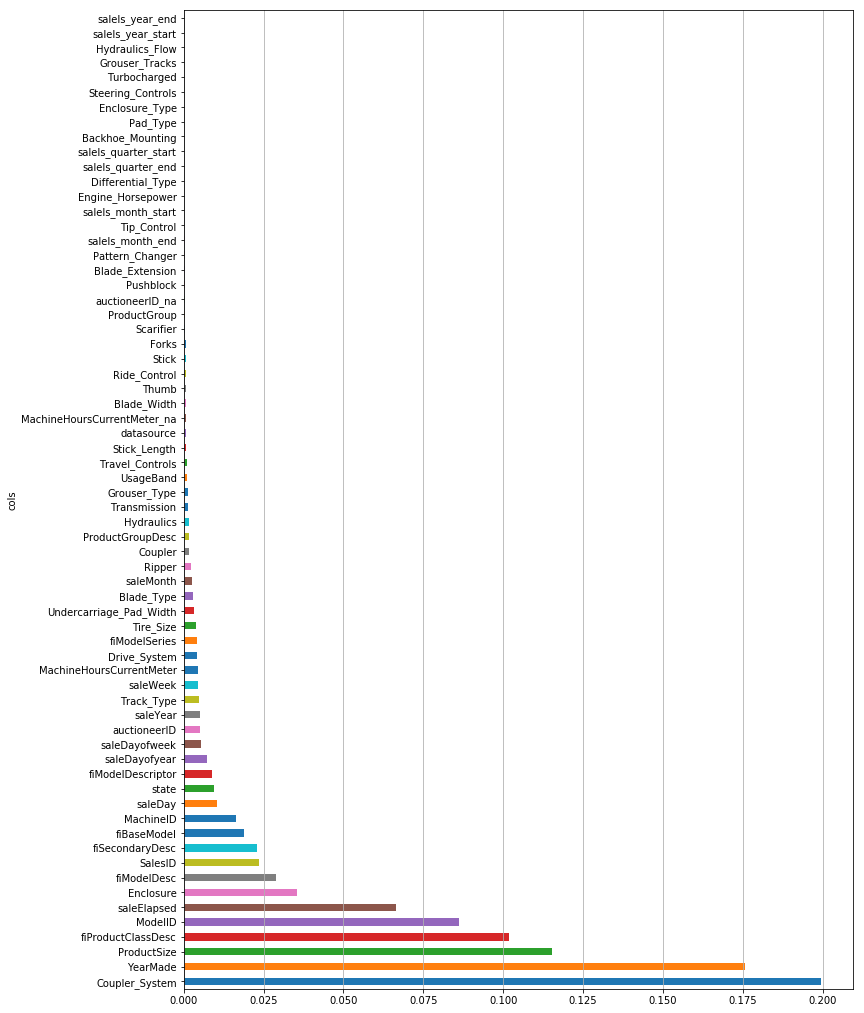

In [21]:
ax = fi.plot('cols', 'imp', 'barh', figsize=(12,18), legend=False, grid=True);
ax.yaxis.grid(False)

What happens if we run a RFR using only the most "important" features

In [22]:
to_keep = fi[fi.imp>0.005].cols;
df_keep = deepcopy(df_trn[to_keep])
X_train, X_valid = split_train_val(df_keep, n_trn)

In [23]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.12337694573392731
Validation rmse: 0.22422069837595537
Training Score: 0.9681871296351495
Validation Score: 0.9102159119460436
OOB Score: 0.9099037584171774


This shouldn't make nuch of a difference in the predictor. Might result in a slight increase

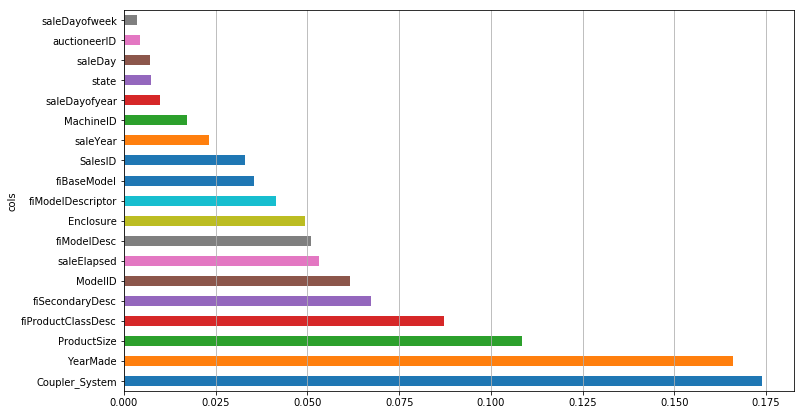

In [24]:
fi = rf_feat_importance(m, df_keep)
ax = fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False, grid=True);
ax.yaxis.grid(False)

You can see that the importance of certain features has changed.

## Calculating the feature importance ??????????

One way to determine the importance of any feature is to take that feature and mix up all its values and see how much the score decreases by.  I will be using less samples, just to make the calculations go faster (if slightly less accurate).

In [95]:
df, y, na_dict = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_train_val(df_trn,trn_amount=n_trn)
y_train, y_valid = split_train_val(y,trn_amount=n_trn)
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, bootstrap=False, min_samples_leaf=9)
m.fit(X_train, y_train)
Score_orig = (m.score(X_train, y_train),m.score(X_valid, y_valid))
Score_orig

(0.9999999999957294, 0.7990585279201616)

In [130]:
smp_sz = 40000
df_small = df_raw.sample(smp_sz,random_state=42)
df, y, na_dict = proc_df(df_small, 'SalePrice')

In [149]:
n_trn = len(df)-12000
X_train, X_valid = split_train_val(df,trn_amount=n_trn)
y_train, y_valid = split_train_val(y,trn_amount=n_trn)
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, bootstrap=True, min_samples_leaf=9)
m.fit(X_train, y_train)
Score_orig = (m.score(X_train, y_train),m.score(X_valid, y_valid))
Score_orig

(0.9116163188588868, 0.8532882027452973)

In [94]:
n_trn

389125

In [54]:
fi = rf_feat_importance(m, df_trn)
feat_list = fi.iloc[:,0].tolist()

In [135]:
X_train.shape

(40000, 66)

In [153]:
X_feat = X_train.copy()
X_feat[feat_list[0]] = X_feat[feat_list[0]].sample(len(X_feat),random_state=42)
m.fit(X_feat, y_train)
(Score_orig[0] - m.score(X_feat, y_train),Score_orig[1] - m.score(X_valid, y_valid))

(-0.0003737334203067766, -0.0005571893310599707)

In [148]:
X_feat = X_train.copy()
X_feat[feat_list[25]] = X_feat[feat_list[25]].sample(len(X_feat),random_state=42)
m.fit(X_train, y_train)
(Score_orig[0] - m.score(X_train, y_train),Score_orig[1] - m.score(X_valid, y_valid))

(-0.0003147761753081735, -0.0011365767246251934)

In [93]:
df_feat = df_raw.copy()
df_feat[feat_list[25]] = df_feat[feat_list[25]].sample(trn_amount,random_state=42)
df_trn, y_trn, nas = proc_df(df_feat, 'SalePrice')
_, X_valid = split_train_val(df,trn_amount=n_trn)
_, y_valid = split_train_val(y,trn_amount=n_trn)
X_train, _ = split_train_val(df_trn, trn_amount)
y_train, _ = split_train_val(y_trn, trn_amount)
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, bootstrap=False)
m.fit(X_train, y_train)
(Score_orig[0] - m.score(X_train, y_train),Score_orig[1] - m.score(X_valid, y_valid))

(0.0, 0.0005362142958822425)

## When to be wary of feature importance/feature engineering

1. overfitting the model (oob_score should decrease if overfitting)
1. Finding something true about the training data which is not true about the validation data, e.g., time series data in which the training data is randomly sampled but validation data is not random, but a specific time period.

## One hot encoding

Let's say you are trying to predict which type of car sells the best and the most importanct factor is the size of the car, e.g., minicompact, subcompact, compact, mid-size, and large.  More specifically, let's say that whether a car is mid-size or not is the best predictor of the number of sales.  You were diligent in your preprocessing and ordered the categorical variables where applicable, so that when transformed to a numeric column the sizes match up as follows:

 - unknown = 0
 - minicompact = 1
 - subcompact = 2
 - compact = 3
 - mid-size = 4
 - large = 5

In order for the RF to parse this property it has to make two splits, e.g., size less thna / greater than 4.5 and size less than / greater than 3.5.  The only real issue with needing multiple splits to get at a single value is it wastes splits.  Since the most splits possible for any RF model is the $\log_2(d)$, where $d$ is the number of variables, every 10 fold increase in $d$ only increases the total split count by about 3.  So even if there are 1,000 variables, you can only do about 10 splits.  So wasting them is not ideal.

This is where one-hot encoding comes in. Instead of representing all options as different values in one column, you split out each value into its own binary variable.  So in the car sizes example, one column would be weather the car is a minicompact, another would be, whether the car is a subcompact, and so on.  This shouldn't take the model that much longer to process as there are still the same number of values just spread out over multiple columns.  The downside of one-hot encoding is that if there is a a split in the values, such as all cars subcompact or smaller, sell really well, then one-hot encoding requires more splits than the standard RF.  However, this issue only appears when the data is first properly organized for every value, and when the desired values are contiguous.  If the values are not continguous, either due to a lack fo proper ordering or because the values that matter are dissimilar, then one-hot encoding does the better job.  For example in the car case if subcompacts and mid-size cars sold the best, then the stanrd RF has to make 4 splits to tease that out, while the ohe-hot encoded RF only has to make 2 splits. There are two factors to be aware of with one-hot encoding

1. The number of columns can get ridiculous. 
1. The maximum number of unique values per variable to one-hot encode.  For example if you set this at 7 and a variable had 8 possible values, it would not one-hot encode it.  This mitigates the issues created by the first factor.  

In [166]:
n_trn = len(df_raw)-12000
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_train_val(df_trn2, n_trn)
y_train, y_valid = split_train_val(y_trn, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.11800419237222408
Validation rmse: 0.23456441391870053
Training Score: 0.9708975400740971
Validation Score: 0.9017410260593375
OOB Score: 0.9105081441475771


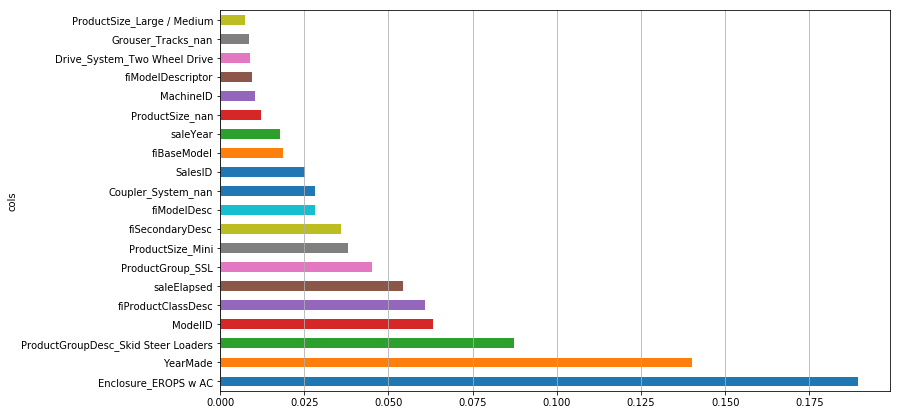

In [169]:
fi = rf_feat_importance(m, df_trn2)
ax = fi[:20].plot('cols', 'imp', 'barh', figsize=(12,7), legend=False, grid=True);
ax.yaxis.grid(False)

## Detecting redundant features

Sometimes you can have multiple features that repeat the same information to the model.  For example let's say I was modeling car sales and two of my variables were car size class and number of seats.  These two variables are expressing the same underlying property of the car and as a result are veyry highly correlated.  

These types of features are a problem because they can dilute the importance of each feature individually.  For example if in half the models the RF split on number of seats and half the time it split on car size, the relative importance of the underlying feature would be reduced by half.  So you want a method of detecting redundant features.

One way of doing this is through a dendrogram.

In [170]:
from scipy.cluster import hierarchy as hc

Note that in the graphs below, I used the spearman rank correlation and not the standard pearson correlation.  The reason for this switch is left as an exercise for the reader.  Just joking.  The standard pearson's correlation assesses a linear relationship between two continuous variables without outliers (typically defined as $\pm 3.29$ $sd$ away from the mean).  Since random forests typically deal with both a mix of ordinal and continuous variables the spearman rank correlation is preferred.  The spearman rank correlation essentailly just ranks the $n$ values along each axis from 1 (lowest value along that axis) to $n$ (highest value along that axis) and then effectively calculates the correlation on the ranks.  So regardless of the shape of the data points along the graph, if an increase in $x$ always produces and increase in $y$ then the spearman rank correlation will be 1. 

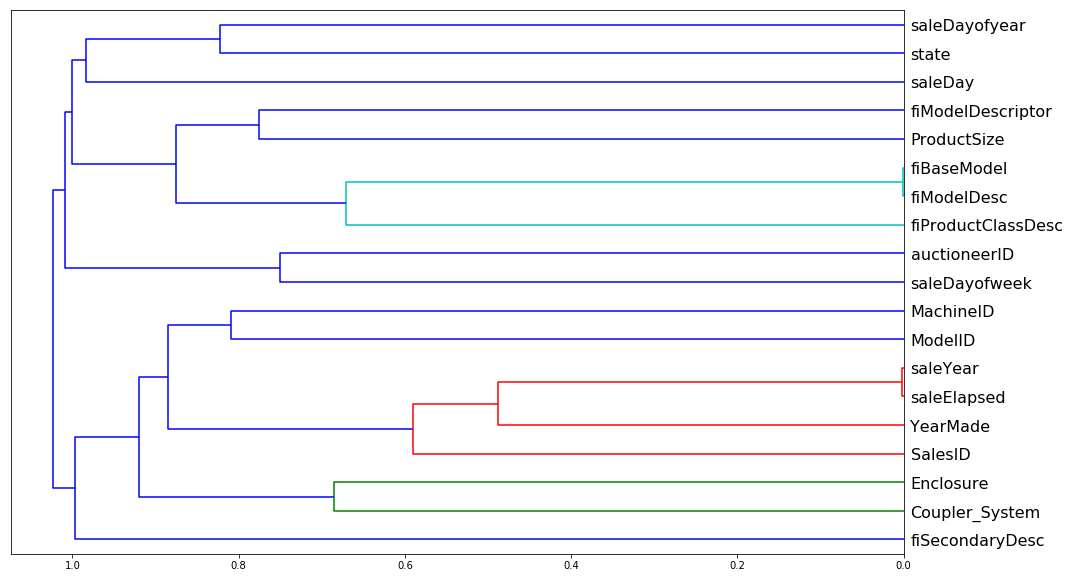

In [174]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

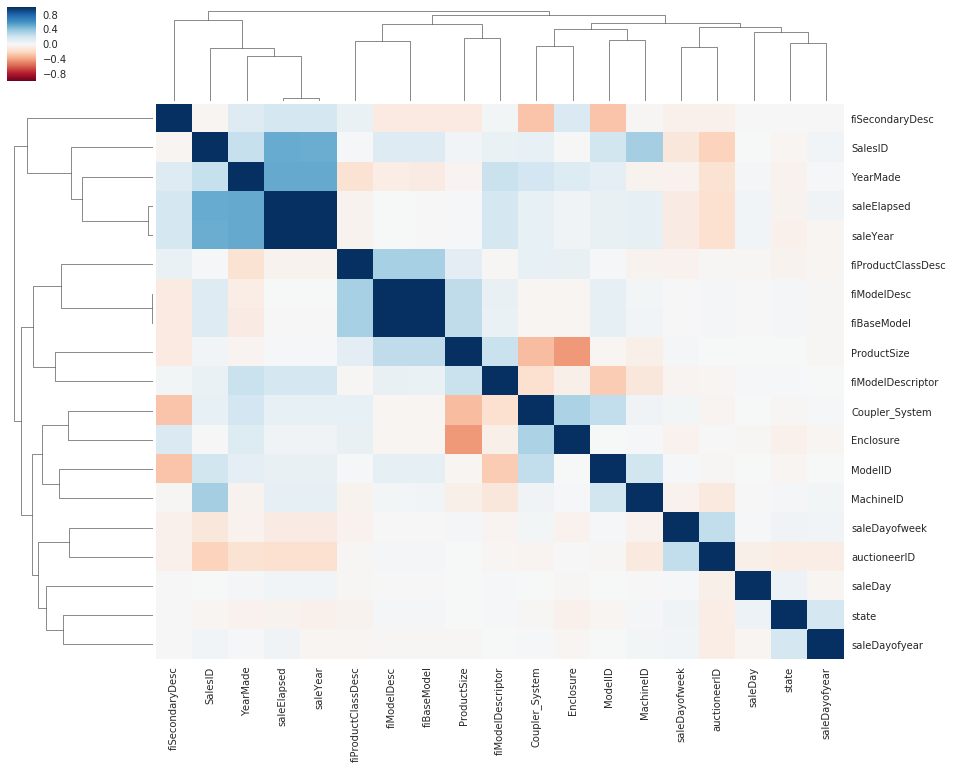

In [223]:
g = sns.clustermap(corr,xticklabels=df_keep.columns,yticklabels=df_keep.columns,figsize=(15,12),cmap='RdBu',vmin=-1,vmax=1)

To quantify the degree to which removing each of these "redundant" features affect the RF, i can remove one at a time and evaluate the resulting oob_score.  

In [263]:
corr_list = []
corr_tuple = []
thresh = 0.5
corr_fill = np.copy(corr)
np.fill_diagonal(corr_fill,0)
for i,v in pd.DataFrame(corr_fill,index=df_keep.columns,columns=df_keep.columns).iterrows():
    if len(v[v>thresh] > 0):
        corr_list.append(i) 
        corr_list += (v[v>thresh]).index.tolist()
        corr_tuple += [i,(v[v>thresh]).index.tolist()]
corr_set = set(corr_list)
corr_set

{'SalesID',
 'YearMade',
 'fiBaseModel',
 'fiModelDesc',
 'saleElapsed',
 'saleYear'}

In [233]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=9, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_train_val(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [262]:
print(get_oob(df_keep))
for i in corr_set:
    print(i, get_oob(df_keep.drop(i, axis=1)))

0.9030278830836228


/data/msnow/miniconda3/envs/data_sci/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


saleYear 0.9024768799425593


/data/msnow/miniconda3/envs/data_sci/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


YearMade 0.8876662740793434
fiBaseModel 0.9026417316764233
fiModelDesc 0.9019408318854962


/data/msnow/miniconda3/envs/data_sci/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


SalesID 0.9019152625396869
saleElapsed 0.9006533182094998


In [264]:
corr_tuple

['YearMade',
 ['saleElapsed', 'saleYear'],
 'saleElapsed',
 ['YearMade', 'SalesID', 'saleYear'],
 'fiModelDesc',
 ['fiBaseModel'],
 'SalesID',
 ['saleElapsed'],
 'fiBaseModel',
 ['fiModelDesc'],
 'saleYear',
 ['YearMade', 'saleElapsed']]

Looking at the changes in oob_score I can drop `saleYear`, `fiBaseModel`, `fiModelDesc`, `SalesID` and `saleElapsed` and only have a 3rd decimal point difference in oob_score.  But rememeber I need to always keep one feature from every redundant set, which I can see using the `corr_tuple` variable.  So it looks like I can drop `saleYear`, `SalesID` and `saleElapsed`, as well as either `fiBaseModel` or `fiModelDesc`.

Let's see what happens to the oob_score when I drop those columns

In [273]:
to_drop = ['saleYear', 'SalesID', 'saleElapsed', 'fiBaseModel']
get_oob(df_keep.drop(to_drop, axis=1))

0.8316108884365241

In [272]:
to_drop = ['SalesID', 'saleYear', 'fiBaseModel']
get_oob(df_keep.drop(to_drop, axis=1))

0.9022593544453603

In [275]:
to_drop = ['SalesID', 'saleElapsed', 'fiBaseModel']
get_oob(df_keep.drop(to_drop, axis=1))

0.9001483248124548

Interestingly it looks like I can drop either `saleElapsed` or `saleYear`, but not both. 

Let's create a new dataframe of columns to keep, dropping these redundant features.

In [276]:
to_drop = ['SalesID', 'saleYear', 'fiBaseModel']
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_train_val(df_keep, n_trn)

In [277]:
reset_rf_samples()

In [278]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.1270607676628979
Validation rmse: 0.2232201612012222
Training Score: 0.9662590135187847
Validation Score: 0.9110154089562776
OOB Score: 0.9081848988896525


# Feature Understanding

Let's now take a look at how some of the features with the highest importance relate to the outcome of interest

In [280]:
set_rf_samples(50000)

In [282]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_train_val(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

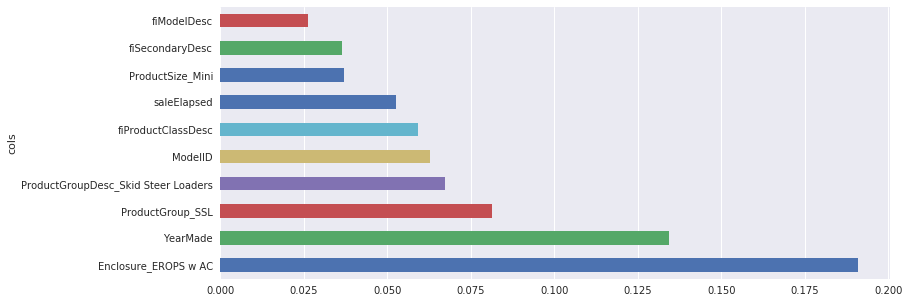

In [288]:
fi = rf_feat_importance(m, df_trn2); 
ax = fi[:10].plot('cols', 'imp', 'barh', figsize=(12,5), legend=False, grid=True);
ax.yaxis.grid(False)

`YearMade` seems to be one of the most important features.  How does that relate to the sale price

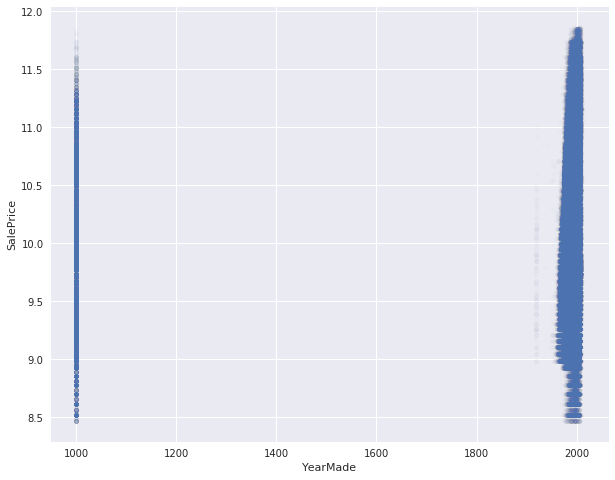

In [289]:
df_raw.plot('YearMade','SalePrice','scatter',alpha=0.01, figsize=(10,8))

The first thing to notice is that there seems to be a lot of vehicles mace in the year 1000.  This probably means that vehicles manufactured before a certain date or vehicles without a year made entry are just given the value of 1000.  Let's replot this data, but only looking at valid `YearMade` entries

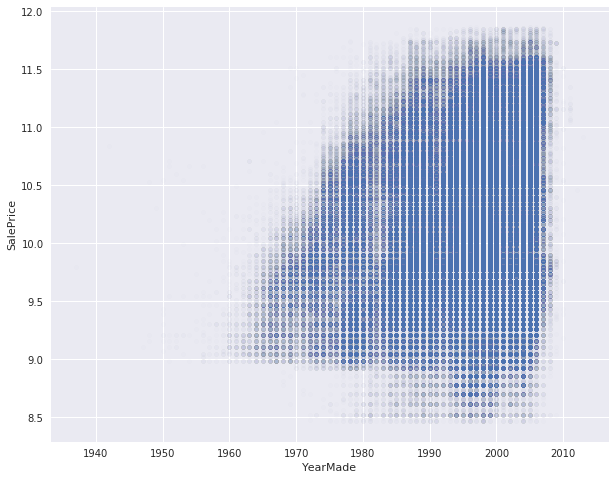

In [304]:
df_raw[df_raw.YearMade>1930].plot('YearMade','SalePrice','scatter',alpha=0.01, figsize=(10,8))

There definitely does seem to be some correlation between `YearMade` and `SalePrice`.  In order ot visualize this data in a more meaningful way, let's take a look at the average `SalePrice` as a function of `YearMade` and plot that along with its standard deviation. To do that I am going to use the plotnine package, which is a python implementation of the R plotting package ggplot.  Within ggplot there is a plot called stat_smooth, which plots the average and standard deviation using a smoothing function and here we are using the `loess` setting which tells it to fit a polynomial surface to the data in local regions, i.e., take each chunk of points and fit a polynomial to that section only.

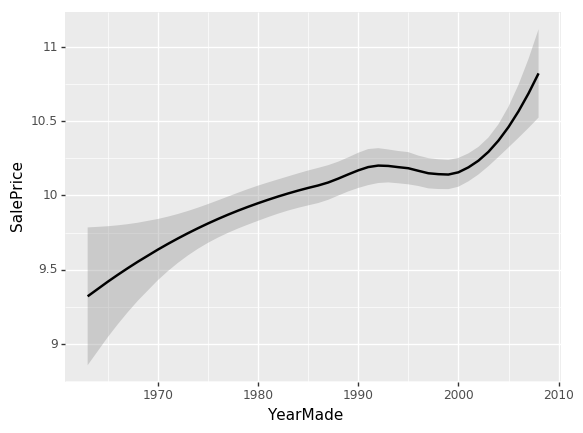

<ggplot: (-9223363282133964533)>

In [303]:
x_all = df_raw[df_raw.YearMade>1930].sample(500)
ggplot(x_all, aes('YearMade', 'SalePrice')) + stat_smooth(se=True, method='loess')

A cursory analysis of this data seems to imply that `SalePrice` rose steadily besides for a dip in the late 1990's.  But is this actually true.  There are lots of variables which influence the `SalePrice`, if we kept all of them constant except for `YearMade` would we still see the same trend.

To get at this we can use a package called [pdpbox](https://github.com/SauceCat/PDPbox).  This package was built to help understand the realtionships between predictors and outcomes.  As the package says in its documentation: 
> For example, in terms of random forest, all we get is the feature importance. Although we can know which feature is significantly influencing the outcome based on the importance calculation, it really sucks that we don’t know in which direction it is influencing. And in most of the real cases, the effect is non-monotonic. 

The way pdpbox works is that it for each value of a specific feature (or value percentiles for continuous values more than the threshold), it creates a new dataset where all the other features are the same, but the feature of interest is kept constant.  Predictions are made for that value of the feature of interest.  This is repeated for all values.  What you end up with is for every observation you have the predicted outcome as a function of every value in the feature of interest. 

For example, let's say we have the following dataset, where `Var2` is our feature of interest and `Outcome` is the predicted outcome.

| Outcome | Var1      | Var2  |
| --------|:---------:| -----:|
| O1      | V1_1      |  V2_1 |
| O2      | V1_2      |  V2_2 |
| O3      | V1_3      |  V2_3 |

pdpbox creates 3 new datasets

| Outcome | Var1      | Var2  |
| --------|:---------:| -----:|
| O1(1)      | V1_1(1)      |  V2_1 |
| O2(1)      | V1_2(1)      |  V2_1 |
| O3(1)      | V1_3(1)      |  V2_1 |

| Outcome | Var1      | Var2  |
| --------|:---------:| -----:|
| O1(2)      | V1_1(2)      |  V2_2 |
| O2(2)      | V1_2(2)      |  V2_2 |
| O3(2)      | V1_3(2)      |  V2_2 |

| Outcome | Var1      | Var2  |
| --------|:---------:| -----:|
| O1(3)      | V1_1(3)      |  V2_3 |
| O2(3)      | V1_2(3)      |  V2_3 |
| O3(3)      | V1_3(3)      |  V2_3 |

You can then plot the outcomes for each observation as a function of Var2

| V2_1 | V2_2      | V2_3  |
| --------|:---------:| -----:|
| O1(1)      | O1(2)      |  O1(3) |
| O2(1)      | O2(2)      |  O2(3) |
| O3(1)      | O3(2)      |  O3(3) |


In [306]:
def plot_pdp(feat, training_set, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, training_set, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

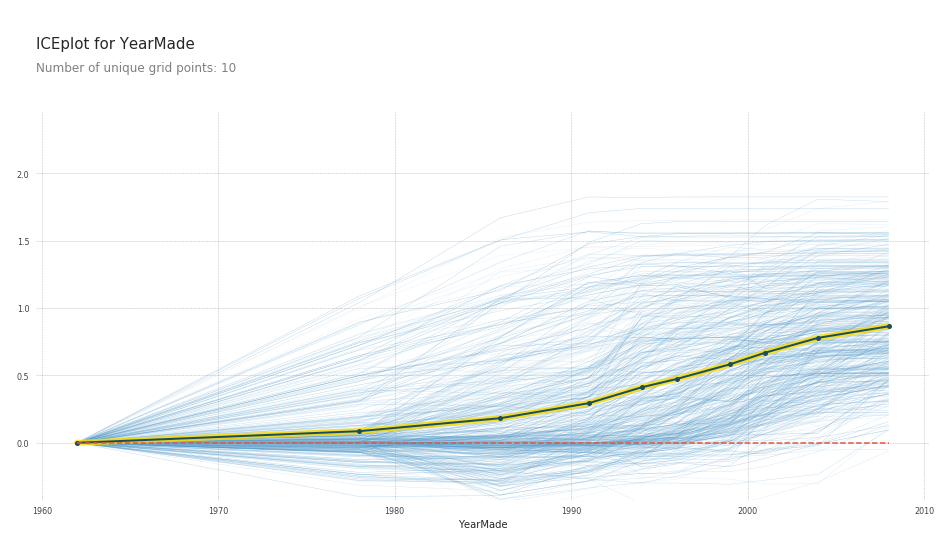

In [316]:
feat_name = 'YearMade'
x_trn = X_train[X_train[feat_name]>1930].sample(500)
p = pdp.pdp_isolate(m, x_trn, feat_name)
pdp.pdp_plot(p, feat_name, plot_lines=True)
# plot_pdp(,x_trn)

In addition to the individual lines, pdp also plots the average prediction for each value.  

We can also cluster the lines to parse out possible specific trends

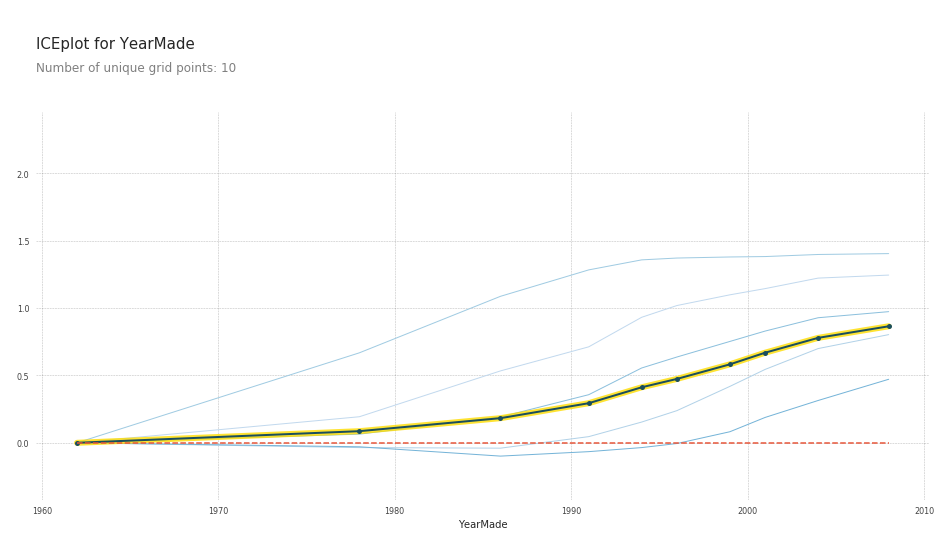

In [318]:
pdp.pdp_plot(p, feat_name, plot_lines=True, cluster=True, n_cluster_centers=5)

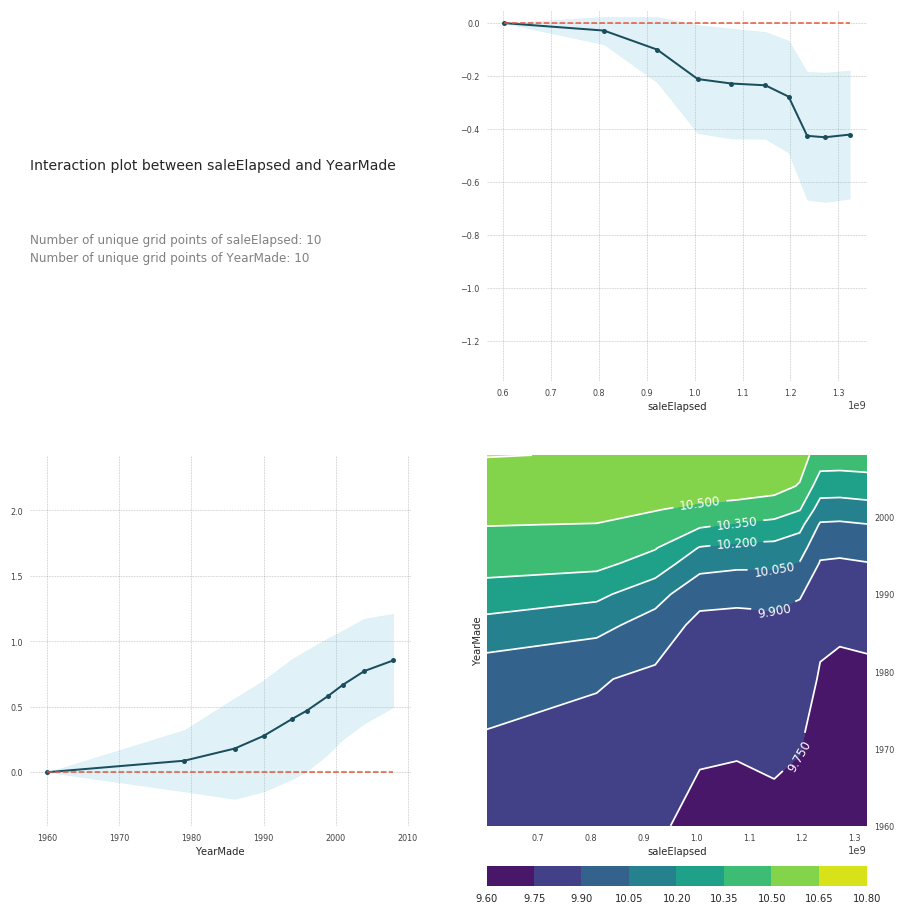

In [313]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x_trn, feats)
pdp.pdp_interact_plot(p, feats)

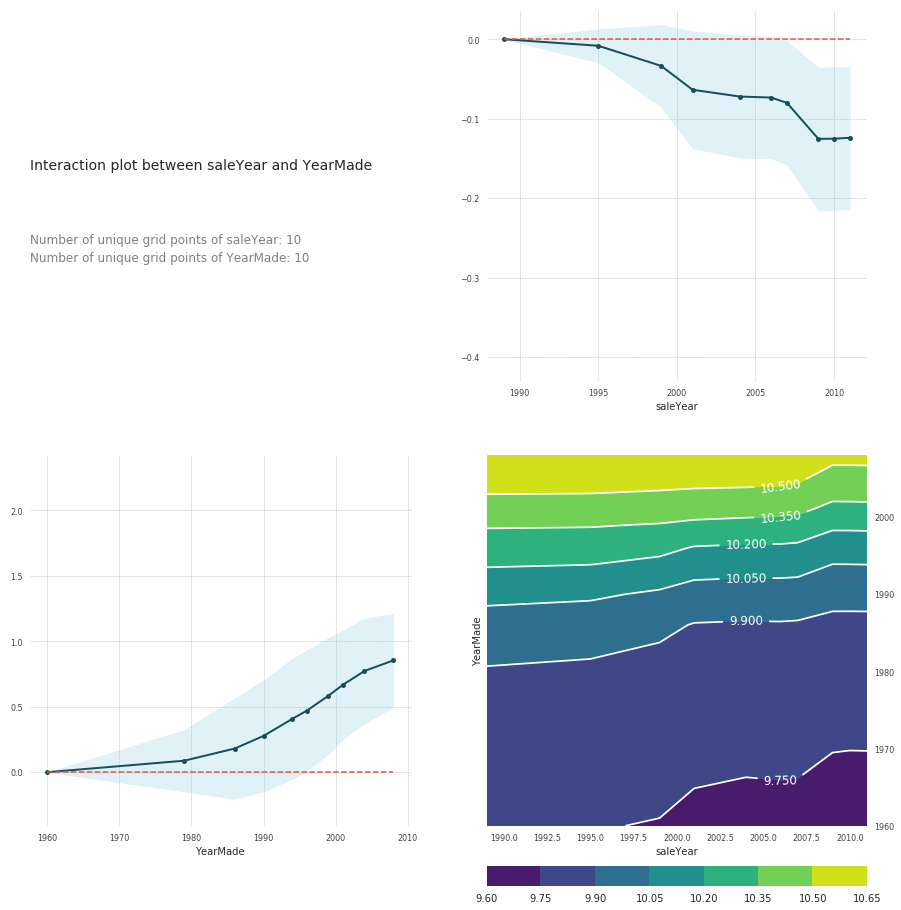

In [314]:
feats = ['saleYear', 'YearMade']
p = pdp.pdp_interact(m, x_trn, feats)
pdp.pdp_interact_plot(p, feats)

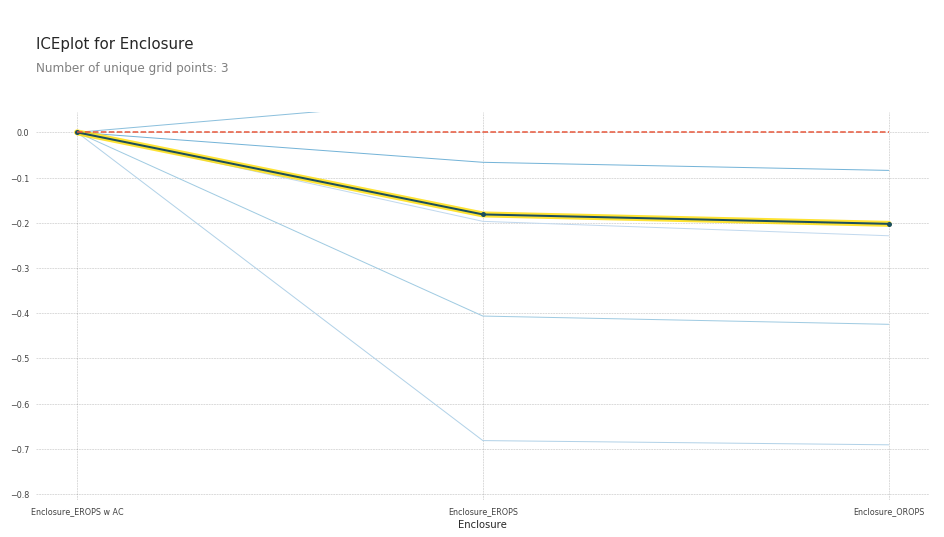

In [311]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], x_trn, 5, 'Enclosure')

# RF with very large datasets

This dataset is from the kaggle competition [Corporación Favorita Grocery Sales Forecasting](https://www.kaggle.com/c/favorita-grocery-sales-forecasting).  And has been munged in the data_munging notebook

In [13]:
g_raw = pd.read_feather(f'{DATA}favorita/groceries')

ArrowException: Unknown error: 

In [92]:
df_g, y_g, na_dict = proc_df(g_raw, 'unit_sales')

In [ ]:
n_valid = 3370464 # size of the test set
n_trn = len(g_raw) - n_valid
_, X_valid = split_train_val(df,trn_amount=n_trn)
_, y_valid = split_train_val(y,trn_amount=n_trn)
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=na_dict)
X_train, _ = split_train_val(df_trn, trn_amount=20000)
y_train, _ = split_train_val(y_trn, trn_amount=20000)